In [116]:
from astropy.io import fits
from astropy.table import Table, vstack, hstack
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Data

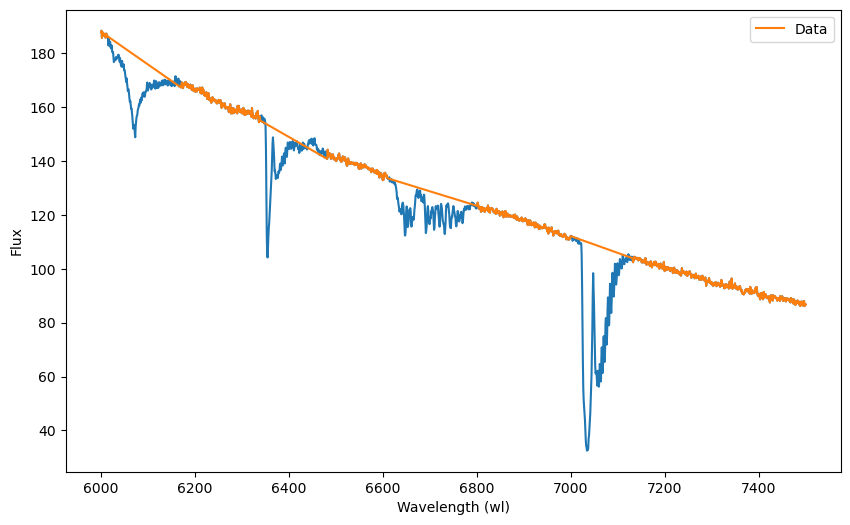

In [151]:
#file_name = 'bundle_20230529_standards/combined_spectrum_20230112_0000009_exp01.fits'
file_name = 'bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
wl = wl/(1+z)
flux = data[1] *(10**16)
err = data[2]

mask0 = np.where((wl>6000) & (wl < 7500)) 
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]

mask1 = np.where((wl_o < 6015) | (wl_o > 6170)) 
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6480)) 
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6610) | (wl > 6800)) 
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130)) 
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]

plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o)
plt.plot(wl, flux, label='Data')  # Original data

#plt.plot(wl_fit, flux_fit-flux_o, label='Best fit curve')  # Fitted curve
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
plt.legend()
plt.show()

# Functions

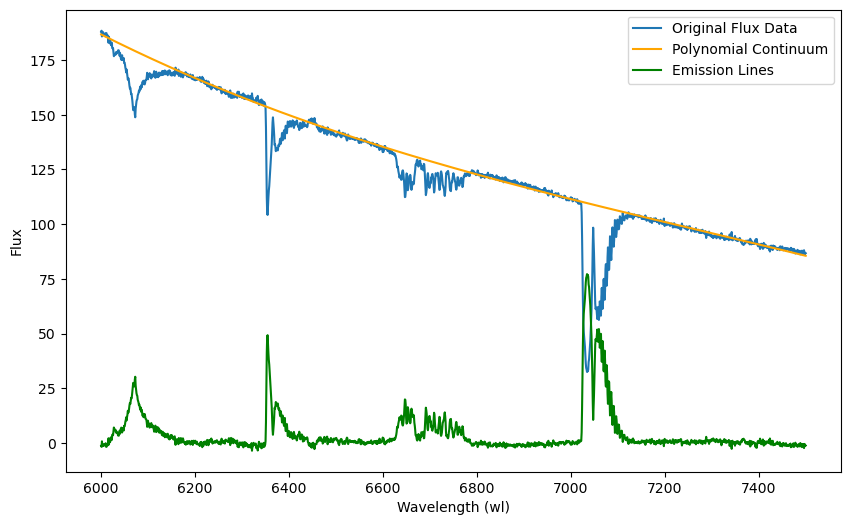

In [152]:
degree = 3
coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = polynomial_continuum - flux_o
standard_wl = wl_o


plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o, label='Original Flux Data')
plt.plot(wl_o, polynomial_continuum, label='Polynomial Continuum', color='orange')
plt.plot(standard_wl, standard_flux, label='Emission Lines', color='green')
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
plt.legend()
plt.show()

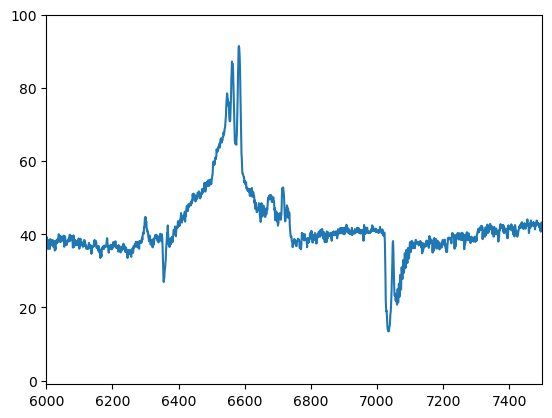

In [153]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda']

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6000)&(source_wl<7500))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]


plt.plot(source_wl, source_flux)
plt.xlim(6000, 7500)
plt.ylim(-1, 100)
plt.show()

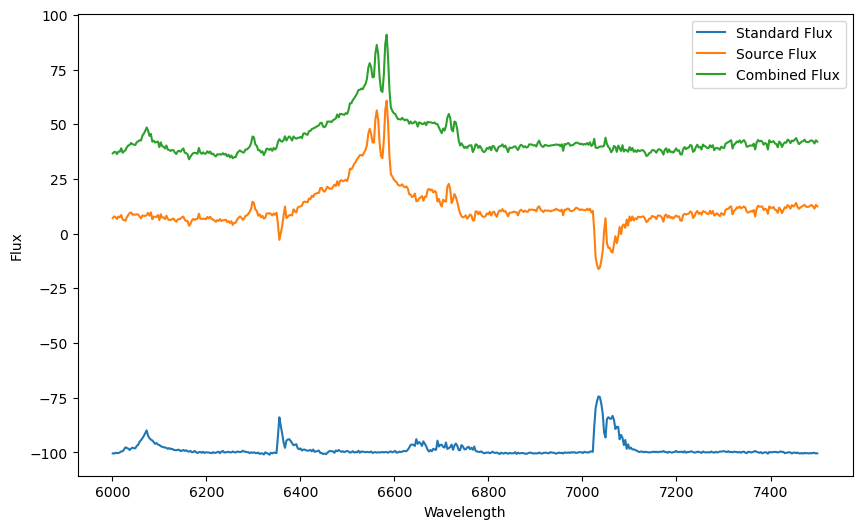

In [155]:
common_wl = np.linspace(min(min(source_wl), min(standard_wl)), max(max(source_wl), max(standard_wl)), num=500)

# Step 2 & 3: Interpolate both datasets to the common wavelength grid
interp_func1 = interp1d(standard_wl, standard_flux, kind='cubic', bounds_error=False, fill_value='extrapolate')
interp_func2 = interp1d(source_wl, source_flux, kind='cubic', bounds_error=False, fill_value='extrapolate')

interpolated_flux1 = interp_func1(common_wl)
interpolated_flux2 = interp_func2(common_wl)

combined_flux = interpolated_flux1/3 + interpolated_flux2
corrected_flux =  interpolated_flux2 - interpolated_flux1

plt.figure(figsize=(10, 6))
plt.plot(common_wl, interpolated_flux1/3-100, label="Standard Flux")
plt.plot(common_wl, interpolated_flux2-30, label="Source Flux")
plt.plot(common_wl, combined_flux, label='Combined Flux')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()
